# Reproducing Experiment 1

For each of the nine weather contexts, we obtained the number of participants who gave each of the weather state ratings. By performing add-one Laplace smoothing on the counts, we computed a smoothed prior distribution over weather states given each context, namely $P(s)$ (Figure 3). 

In [1]:
import numpy as np
import pandas
df = pandas.read_csv("data/priors/long.csv")

In [2]:
df.sort_values(by=["imageID"])[:10] #just so we can see the data organized

,workerID,gender,age,income,language,order,imageID,imageCategory,stateRating,sad,disgusted,angry,neutral,content,happy,excited
102,13,F,45,0,English,4,1,amazing,4,0.21,0.04,0.04,0.42,0.81,0.68,0.52
337,39,F,45,4,English,5,1,amazing,5,0.04,0.06,0.05,0.42,0.42,0.82,0.76
149,18,M,25,6,English,6,1,amazing,5,0.02,0.20,0.14,0.14,0.75,0.83,0.69
221,26,F,65,4,English,6,1,amazing,4,0.01,0.02,0.01,0.53,0.98,0.86,0.80
251,29,F,25,4,English,9,1,amazing,5,0.29,0.06,0.06,0.60,0.74,0.84,0.47
40,5,M,35,4,English,5,1,amazing,5,0.00,0.00,0.01,0.52,1.00,1.00,0.88
136,17,M,35,4,English,2,1,amazing,5,0.02,0.01,0.02,0.17,0.91,0.97,0.97
134,16,F,45,8,English,9,1,amazing,5,0.00,0.00,0.00,0.42,0.73,0.86,0.48
350,40,M,65,4,english,9,1,amazing,4,0.02,0.02,0.01,0.10,0.93,0.78,0.60
47,7,M,35,4,English,3,1,amazing,4,0.30,0.14,0.29,0.39,0.51,0.54,0.53


In [19]:
groups = df[["imageID", "imageCategory", "stateRating"]].groupby('imageID')

value_counts = groups["stateRating"].value_counts()

counts = np.ones((9,5))
for val, cnt in value_counts.iteritems():
    img_id,state = val[0]-1,val[1]-1
    counts[img_id][state] = cnt + 1

priors = counts / counts.sum(axis=1,keepdims=True)  #normalize across rows
priors

array([[ 0.01851852,  0.01851852,  0.01851852,  0.16666667,  0.77777778],
       [ 0.01851852,  0.01851852,  0.01851852,  0.07407407,  0.87037037],
       [ 0.01851852,  0.01851852,  0.01851852,  0.05555556,  0.88888889],
       [ 0.01851852,  0.14814815,  0.51851852,  0.27777778,  0.03703704],
       [ 0.01851852,  0.01851852,  0.22222222,  0.62962963,  0.11111111],
       [ 0.01851852,  0.01851852,  0.18518519,  0.59259259,  0.18518519],
       [ 0.55555556,  0.35185185,  0.05555556,  0.01851852,  0.01851852],
       [ 0.09259259,  0.40740741,  0.33333333,  0.14814815,  0.01851852],
       [ 0.55555556,  0.35185185,  0.05555556,  0.01851852,  0.01851852]])

### Recreate figure 3

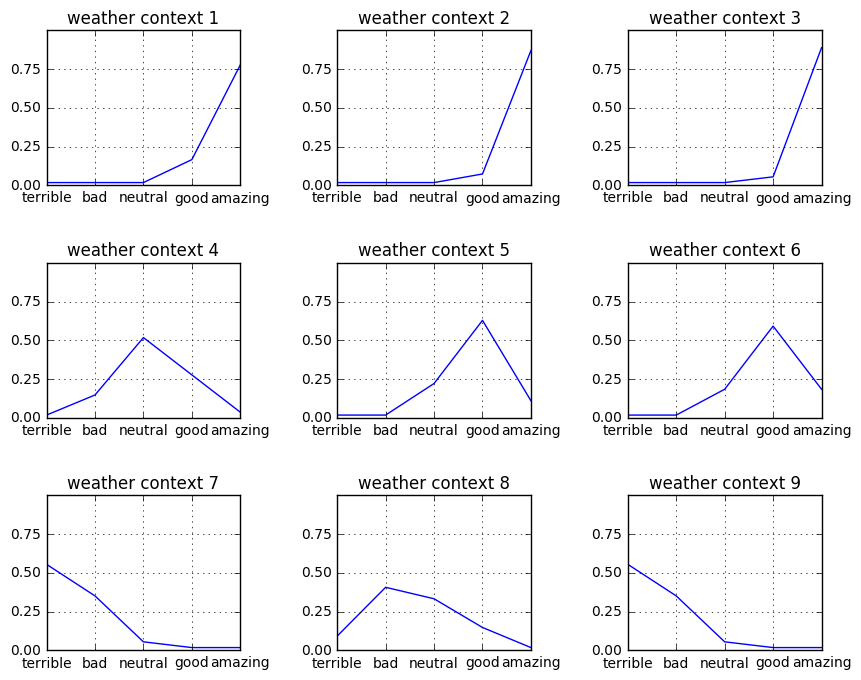

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
labels = ["terrible", "bad", "neutral", "good", "amazing"]
x = np.arange(5)

for index, row in enumerate(priors,1):
    ax1 = fig.add_subplot(33*10+index)
    ax1.set_title("weather context %i"%(index))
    ax1.set_ylim(0, 1)
    ax1.plot(x,row.tolist())
    plt.grid()
    plt.xticks(x, labels) 
    plt.yticks(np.arange(0.0, 1.0, 0.25))
    

fig.subplots_adjust(hspace=.5, wspace=.5)
plt.show()

## PCA
To examine participants’ ratings of the affect associated. with each context, we first performed Principal Component Analysis (PCA) on the seven emotion category ratings. This allowed us to compress the ratings onto a lower-dimensional space and reveal the main affective dimensions that are important in this domain, as is often done in affective science (Russell, 1980).

In [7]:
def pca(m, k):
    from numpy.linalg import svd
    from numpy.linalg import eig
    from numpy.linalg import det
    u,s,v = svd(m)
    rs = np.sqrt(np.diag(s[:k]))
    x=np.dot(u[:,:k], rs)
    y=np.dot(rs, v[:k])
    mhat=np.dot(x, y)
    return s, x, y, mhat

In [25]:
affect = df[["sad", "disgusted", "angry", "neutral", "content", "happy", "excited"]]
s,x,y,mhat = pca(affect,2)
print(x.shape)
print(y.shape)


(441, 2)
(2, 7)


We found that the first two principal components corresponded to the dimensions of emotional valence and emotional arousal, accounting for 69.14% and 13.86% of the variance in the data, respectively. The PCA represents emotion ratings for each trial as real values between negative and positive infinity on each of the dimensions.

## Zero Mean + STD Var
To map these values onto probability space, we first standardized the scores on each dimension to have zero mean and unit variance. 

## CDF to (0,1)
We then used the cumulative distribution function to convert the standardized scores into values between 0 and 1. This gives us the probabilities of Ann feeling positive (vs. negative) valence and high (vs. low) arousal for each trial, which is a two-dimensional probabilistic representation of her affect.

In [6]:
def cdf(data):
    n = len(data)
    x = np.sort(data) # sort your data
    y = np.arange(1, n + 1) / n # calculate cumulative probability
    return x, y

## Avg Probability for each state (across rows for each column)
By calculating the average probabilities of positive valence and high arousal given each weather state rating, we obtain the probability of positive valence and high arousal associated with each weather state, namely $P(A|s)$ (Figure 4).

In [7]:
# I accidently confused affect with state when trying to calculate priors. 
# However this code is pretty neat so I'm going to keep it in case I need it later
# groups = df[["imageID", "sad", "disgusted", "angry", "neutral", "content", "happy", "excited"]].groupby('imageID')
# groups = groups.sum()
# priors = groups.div(groups.sum(axis=1), axis=0) #normalize across rows
# priors